# Bangladesh Multimodal Network Criticality Analysis
Delft University of Technology

Faculty of Technology, Policy and Management

Policy Analysis Section

## 1. Import all required module

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
from __future__ import division

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#Modules developed by TU Delft team for this project
from bangladesh_network_lib import network_prep as net_p
from bangladesh_network_lib import network_visualization as net_v
from bangladesh_network_lib import od_prep as od_p
from bangladesh_network_lib import weighted_betweenness as betw_w

In [38]:
import geopandas as gp

## 2. Network Preparation

Prepare GeoDataFrame of (i) all points in the road network, (ii) location of all centroids, (iii) all roads in the road network 

In [72]:
network = r'./model_input_data/rmms_v11_9_waterway.shp'
centroid = r'./model_input_data/BGD_Districtdata_Citycentroid_level2_v03.shp'



gdf_points, gdf_node_pos, gdf = net_p.prepare_centroids_network(centroid, network)

Reduce the cost to go through waterway

In [73]:
cost_reduction = 0.05
gdf['length'] = gdf.apply(lambda row: (row['length'] * (1 - cost_reduction) if row['mode']=='water' else row['length']), axis=1)

Create Networkx MultiGraph object from the GeoDataFrame

In [74]:
G2_new = net_p.gdf_to_simplified_multidigraph(gdf_node_pos, gdf)

Change the MultiGraph object to Graph object to reduce computation cost 

In [75]:
G2_new_tograph = net_p.multigraph_to_graph(G2_new)

Observe the properties of the Graph object

In [76]:
print('number of disconnected compoents is', nx.number_connected_components(G2_new_tograph))
nx.info(G2_new_tograph)

('number of disconnected compoents is', 7)


'Name: \nType: Graph\nNumber of nodes: 2615\nNumber of edges: 3580\nAverage degree:   2.7380'

Take only the largest subgraph

In [44]:
#take the largest components
for g in nx.connected_component_subgraphs(G2_new_tograph):
    if len(list(g.edges())) > 100:
        G3 = g
        
G2_new_tograph = G3.copy()

Save the simplified transport network back into GeoDataFrame

In [45]:
gdf2 = net_p.graph_to_df(G2_new_tograph)

Prepare the districts statistics

In [77]:
adm_csv = r'./model_input_data/District_level_data_v6.csv'
adm_shp = r'./model_input_data/BGD_adm2.shp'

#Save the following information from csv to DataFrame
district_gdf2 = net_p.prepare_adm_background(adm_csv, adm_shp, ['Code', 'Population', 'Population_M',
                                                               'Garment_ton', 'Steel_ton', 'Jute_ton', 'Textile_ton',
                                                               'Rice_ton', 'Wheat_ton', 'Fruits_ton', 'Potatoes_ton',
                                                               'Sugar_ton', 'Bricks_ton', 'RawJute_loc_ton', 'Total_export',
                                                               'Jute_mill', 'Flour_mill', 'Tot_Garment_Factory', 'Household',
                                                               'Land_throughput'])

Embed the district data to centroids GeoDataFrame 

In [47]:
#read district data
district_data = pd.read_csv(adm_csv)

#rename to HASC_2
district_data.rename(columns={'Code':'HASC_2'}, inplace=True)

#merge them
gdf_points = pd.merge(gdf_points,district_data,on='HASC_2',how='outer')

Ensure that both dataframe have same crs

In [48]:
district_gdf2.crs = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}
gdf2.crs = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}

Special visualization code for plotting multimodality. #TODO: Will be integrated to the main module 

In [70]:
import numpy as np
def _get_percentile(gdf2, col, n):
    #get n-th percentile of a DataFrame column
    get_col = list(gdf2[col])
    get_col = [x for x in get_col if x > 0]
    nth_percentile = np.percentile(get_col, n)

    return nth_percentile

def plot_network_multimodal(gdf, gdf2, colname,betweenness_string, cmaps, maxvals=[0,0],
                            linewidth=1.25, edgecolor='grey', perc1=60, perc2=90,
                            modes=['road', 'water']):
    
    fig, ax = plt.subplots(figsize=(12,9))

    ax.set_aspect('equal')

    cmap_pos = [0.72, 0.45, 0.02, 0.43]
    
    ax.set_title(colname)
    
    gdf3 = gdf2.copy()
    gdf3.sort_values(by='mode', inplace=True)

    for i, mode in enumerate(modes):
        
        gdf_mode = gdf3.loc[gdf3['mode']==mode]

        valmin1 = min(list(gdf_mode[betweenness_string]))
        valmax1 = max(list(gdf_mode[betweenness_string]))
        
        try:
            thres1 = _get_percentile(gdf_mode, betweenness_string, perc1)
            thres2 = _get_percentile(gdf_mode, betweenness_string, perc2)
        except:
            thres1 = 99999
            thres2 = 999999

        gdf_mode.plot(ax=ax, column=betweenness_string, cmap=cmaps[i], vmin=valmin1, vmax=valmax1, linewidth=linewidth)
        
        #add colorbar2
        fig = ax.get_figure()
        axes_pos = cmap_pos
        axes_pos[0] = axes_pos[0] + (0.1*i)
        cax = fig.add_axes(axes_pos)
        sm = plt.cm.ScalarMappable(cmap=cmaps[i])
        columnlist = list(gdf_mode[betweenness_string])
        maxbetweenness = max(columnlist)
        try:
            columnlist.append(maxvals[i])
        except:
            columnlist.append(maxbetweenness)
        cbmin, cbmax = min(columnlist), max(columnlist)
        sm.set_array(columnlist)
        cb = plt.colorbar(sm, cax=cax, label=betweenness_string)
        poin1 = cbmin+(cbmax-cbmin)/4
        poin2 = cbmin+(cbmax-cbmin)/4*2
        poin3 = cbmin+(cbmax-cbmin)/4*3
        labels = [cbmin, poin1, poin2, poin3, cbmax]
        loc = labels
        cb.set_ticks(loc)
        cb.set_ticklabels(labels)
        cb.ax.tick_params(labelsize=16)
        
    for i, mode in enumerate(modes):
        #adjust linewidth based on betweenness
        betweenness_list = list(gdf3[betweenness_string])
        #change the linewidth based on the percentile
        betweenness_list = [1 if x < thres1 else 2 if x >= thres1 and x < thres2 else 3 for x in betweenness_list]
        j = 0
        for ln in ax.lines:
            ln.set_linewidth(betweenness_list[j]*1)
            j +=1
        
    valmin2 = min(list(gdf[colname]))
    valmax2 = max(list(gdf[colname]))
    gdf.plot(ax=ax, column=colname, cmap='Greys',vmin=valmin2, vmax=valmax2, linewidth=0.5, edgecolor=edgecolor, alpha=0.3)
    
    ax.axis('off')
    

## 3. Origin-Demand (OD) Matrix Preparation

Extract the Node ID of all centroid nodes

In [50]:
centroid_nodes = od_p.prepare_centroids_list(G2_new_tograph)

Create deterrence function for OD matrix calculation

In [51]:
#example of deterrence function for all_ods_creation function
#alternatively, the deterrence function argument can be left empty
#in that case, the default deterrence function from the library will be used

def det_func(distance):
    #distance is a n x n DataFrame of euclidean distance between all centroids
    distance = distance*distance
    distance = 100000/distance
    for i in list(distance.columns):
        for j in list(distance.index.values):
            if distance[i][j] > 9999999:
                distance[i][j] = 0
    return distance

Prepare export-based OD

In [52]:
#list of production factors
prod_lists = ['Garment_exp_ton', 'Steel_exp_ton', 'Jute_exp_ton', 'Textile_exp_ton', 
              'Rice_exp_ton','Wheat_exp_ton', 'Fruits_exp_ton', 'Potatoes_exp_ton', 'Sugar_exp_ton', 'Bricks_exp_ton']

#attraction driver
attr_driver='Total_export'

#create the OD dictionary
OD_export_dict = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

OD_export = OD_export_dict[OD_export_dict.keys()[0]]
for i in range(len(OD_export_dict)-1):
    OD_export = OD_export +  OD_export_dict[OD_export_dict.keys()[i+1]]

Prepare land ports export-based OD

In [53]:
#list of production factors
prod_lists = ['Garment_exp_ton', 'Steel_exp_ton', 'Jute_exp_ton', 'Textile_exp_ton', 
              'Rice_exp_ton','Wheat_exp_ton', 'Fruits_exp_ton', 'Potatoes_exp_ton', 'Sugar_exp_ton', 'Bricks_exp_ton']

#attraction driver
attr_driver='Land_throughput'

#create the OD dictionary
OD_land_export_dict = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

OD_land_export = OD_land_export_dict[OD_land_export_dict.keys()[0]]
for i in range(len(OD_land_export_dict)-1):
    OD_land_export = OD_land_export +  OD_land_export_dict[OD_land_export_dict.keys()[i+1]]

Prepare local transaction OD

In [54]:
#local trade OD    
    
#first for products which attraction is population
prod_lists = ['Garment_loc_ton', 'Steel_loc_ton','Jute_loc_ton',
              'Rice_loc_ton', 'Fruits_loc_ton', 'Potatoes_loc_ton', 'Sugar_loc_ton']
attr_driver='Population_x'
OD_local_dict1 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

#next for raw jute
prod_lists = ['RawJute_loc_ton']
attr_driver='Jute_mill'
OD_local_dict2 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

#next for wheat
prod_lists = ['Wheat_loc_ton']
attr_driver='Flour_mill'
OD_local_dict3 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

#next for textile
prod_lists = ['Textile_loc_ton']
attr_driver='Tot_Garment_Factory'
OD_local_dict4 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

#last for bricks
prod_lists = ['Bricks_loc_ton']
attr_driver='Household'
OD_local_dict5 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

Combine all OD dictionaries into final OD Matrix

In [55]:
#Combine all local OD
OD_local1 = OD_local_dict1[OD_local_dict1.keys()[0]]
for i in range(len(OD_local_dict1)-1):
    OD_local1 = OD_local1 +  OD_local_dict1[OD_local_dict1.keys()[i+1]]
    
OD_local2 = OD_local_dict2[OD_local_dict2.keys()[0]]

OD_local3 = OD_local_dict3[OD_local_dict3.keys()[0]]

OD_local4 = OD_local_dict4[OD_local_dict4.keys()[0]]

OD_local5 = OD_local_dict5[OD_local_dict5.keys()[0]]

OD_local_all= OD_local1 + OD_local2 + OD_local3 + OD_local4 + OD_local5

In [56]:
#Create OD_all
OD_all = OD_local_all + OD_export

Create unweighted OD matrix for unweighted betweenness criticality analysis

In [57]:
centroid_district_listed = list(OD_all.columns)

OD_unweighted = pd.DataFrame(1, index=centroid_district_listed, columns=centroid_district_listed)

for i,row in OD_unweighted.iterrows():
    OD_unweighted.loc[i][i] = 0

## 4. Betweenness criticality analysis
Five betweenness criticality analyses are conducted in this part:
1. Weighted betweenness criticality of local economic activities + export activities
2. Weighted betweenness criticality of land ports based export activities
3. Weighted betweenness criticality of local economic activities
4. Weighted betweenness criticality of export activities
5. Unweighted betweenness criticality

The following steps are done for each analysis:
1. Assigning traffic flows to the road network by using Probit assignment in order to find more than one shortest path for each OD pair (in order to take into account drivers' perception error). betw_w.probit_assignment() function does this step.
2. Normalizing the traffic flows in order to get the (weighted) betweenness centrality value. betw_w.edge_betweenness_centrality() function does this step
3. Assigning the betweenness centrality value of each link to the main dataframe for visualization purpose. betw_w.betweenness_to_df() function does this step.
4. Visualization of the corresponding betweenness centrality. net_v.plot_network_admcolmap_betweenness_new() function does this step.

In [22]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_all, N=5, penalty=1.5)

# flow_probit_5 = betw_w.aon_assignment(G=G2_new_tograph, sources=centroid_nodes, 
#                                               targets=centroid_nodes, weight='length', od=OD_all)

betweenness_all_probit = betw_w.edge_betweenness_centrality(flow_probit_5, OD_all)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf2,betweenness_all_probit,'betweenness_all_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_all_probit.values()))
print(e-c)

12661158.828
0.210040509059
0:20:03.802000


In [23]:
gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,flow_probit_5,'flow_probit_5')

In [24]:
total_water = gdf_final.loc[gdf_final['mode']=='water']['flow_probit_5'].sum()
total_road = gdf_final.loc[gdf_final['mode']=='road']['flow_probit_5'].sum()
total_flow = total_water + total_road
perc_water = 100 * total_water / total_flow
perc_road = 100 * total_road / total_flow
print('percentage by road is {} percent'.format(perc_road))
print('percentage by water is {} percent'.format(perc_water))

percentage by road is 90.8615339169 percent
percentage by water is 9.13846608307 percent


In [25]:
#create special colormap
cmap = plt.get_cmap('YlOrRd')
new_cmap1 = net_v.truncate_colormap(cmap, 0.3, 1)
cmap = plt.get_cmap('Blues')
new_cmap2 = net_v.truncate_colormap(cmap, 0.3, 1)

Weighted edge betweenness centrality from local + export based market


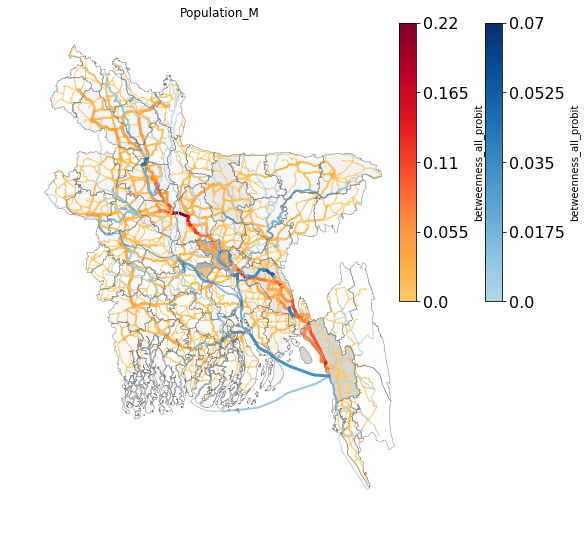

In [183]:
print('Weighted edge betweenness centrality from local + export based market')
plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='betweenness_all_probit', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.22, 0.07],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

In [30]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_land_export, N=5, penalty=1.5)

betweenness_land_export_probit = betw_w.edge_betweenness_centrality(flow_probit_5, OD_land_export)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,betweenness_land_export_probit,'betweenness_land_export_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_land_export_probit.values()))
print(e-c)

2210274.10245
0.217720135371
0:21:13.743000


Weighted edge betweenness centrality from land export based market


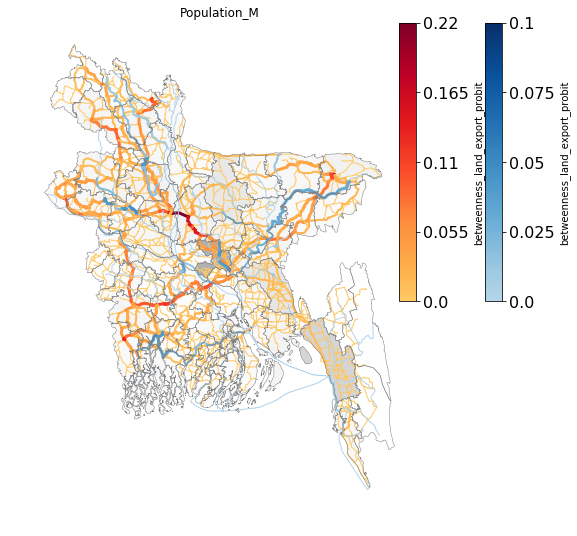

In [184]:
print('Weighted edge betweenness centrality from land export based market')
plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='betweenness_land_export_probit', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.22, 0.1],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

In [32]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_local_all, N=5, penalty=1.5)

betweenness_local_probit = betw_w.edge_betweenness_centrality(flow_probit_5, OD_local_all)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,betweenness_local_probit,'betweenness_local_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_local_probit.values()))
print(e-c)

9908171.52026
0.197658551829
0:20:46.058000


Weighted edge betweenness centrality from local market


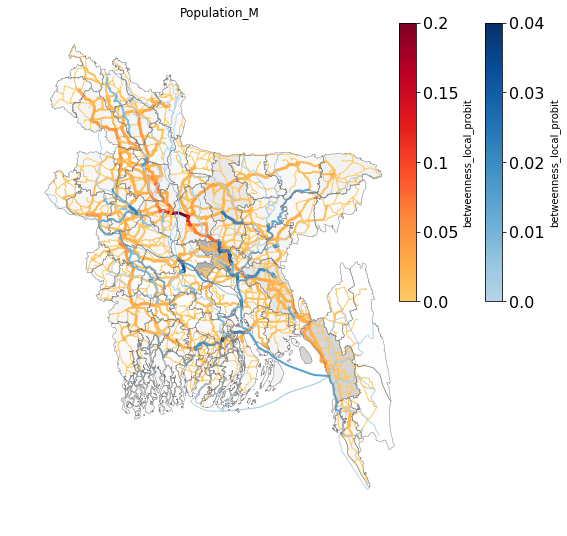

In [185]:
print('Weighted edge betweenness centrality from local market')
plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='betweenness_local_probit', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.2, 0.04],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

In [34]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_export, N=5, penalty=1.5)

betweenness_export_probit = betw_w.edge_betweenness_centrality(flow_probit_5, OD_export)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,betweenness_export_probit,'betweenness_export_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_export_probit.values()))
print(e-c)

7148707.51178
0.704175055323
0:23:06.077000


Weighted edge betweenness centrality from export based market


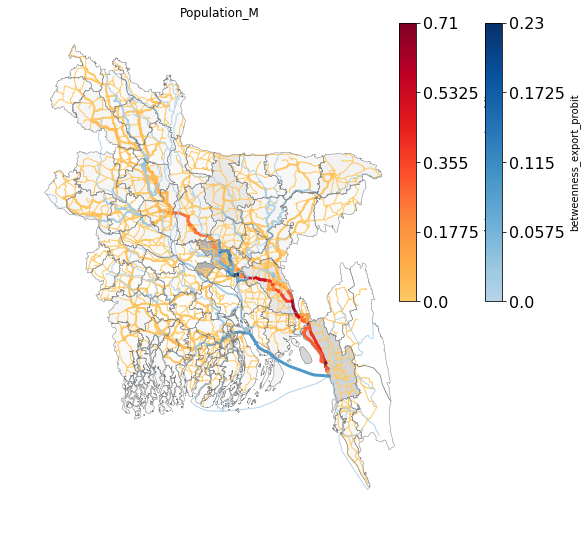

In [186]:
print('Weighted edge betweenness centrality from export based market')
plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='betweenness_export_probit', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.71, 0.23],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

In [36]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.aon_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_unweighted)

betweenness_unweighted = betw_w.edge_betweenness_centrality(flow_probit_5, OD_unweighted)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,betweenness_unweighted,'betweenness_unweighted')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_unweighted.values()))
print(e-c)

1070
0.265376984127
0:02:17.183000


Unweighted edge betweenness centrality


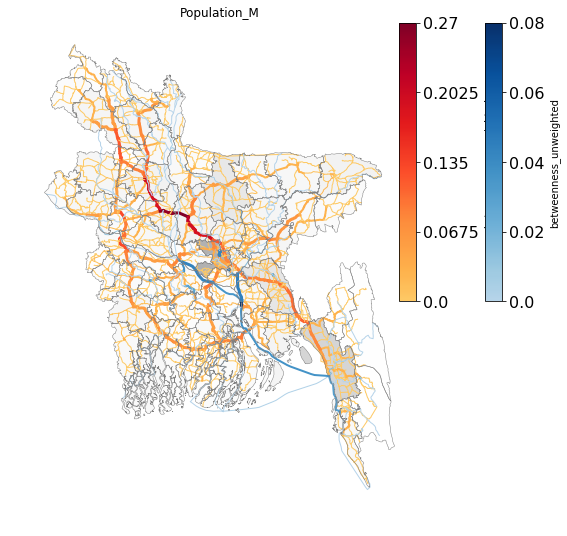

In [187]:
print('Unweighted edge betweenness centrality')
plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='betweenness_unweighted', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.27, 0.08],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

## 5. Minimum edge cut centrality

Save the links cut set for each OD pair. Links cut set are set of links which if simultaneously removed will disconnect a specific OD pair

In [49]:
import datetime
c = datetime.datetime.now()

testcut = []
for i in range(len(centroid_nodes)):
    for j in range(len(centroid_nodes)):
        if i != j:
            testcut2 = nx.minimum_edge_cut(G=G2_new_tograph, s=centroid_nodes[i], t=centroid_nodes[j])
            testcut += testcut2    

e = datetime.datetime.now()
print(e-c)

0:17:49.232000


Create dictionary which stores the occurence of each edge in all cut sets

In [50]:
#save the edge IDs as dictionary key
edgecut_dict = {}
for edge in list(G2_new_tograph.edges()):
    edgecut_dict.update({edge: 0})

In [51]:
#increment the value of the dictionary's key if an edge belongs in a cut set
for i in testcut:
    try:
        edgecut_dict[i] += 1
    except:
        new_tup = tuple([i[1], i[0]])
        edgecut_dict[new_tup] += 1

Save the edge cut set criticality information to the main dataframe

In [52]:
#make a copy, just to be save
gdf_final2 = gdf_final.copy()

#append the edge cut set criticality information
gdf_final2, betweenness_df = betw_w.betweenness_to_df(gdf_final2,edgecut_dict,'Min_EdgeCut_Criticality')

Visualization for minimum edge cut set criticality

Minimum edge cut criticality


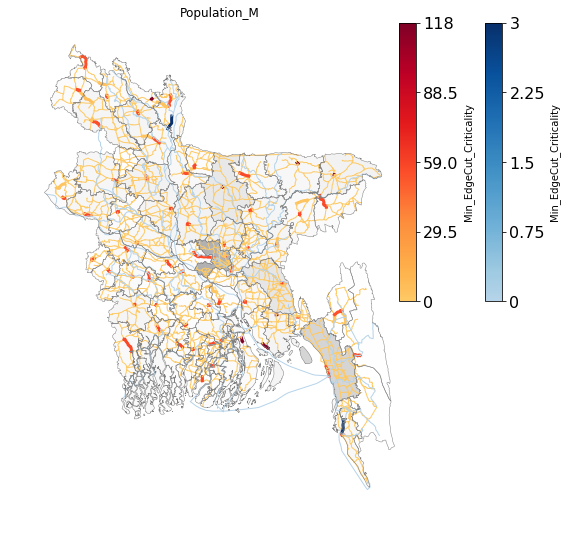

In [188]:
print('Minimum edge cut criticality')
plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final2, colname='Population_M',
                        betweenness_string='Min_EdgeCut_Criticality', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.25, 0.15],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

## 6. Interdiction criticality
Iteratively and independently remove each link one by one, then recalculate the total transport cost (sum of distance traveled * flows magnitude). In this analysis, AON

First record the shortest paths for each OD pair into a dictionary

In [60]:
sp_dict_graph = betw_w.sp_dict_graph_creation(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length')

Then run the interdiction algorithm

In [61]:
import datetime
timestart = datetime.datetime.now()

new_interdiction_dict, new_disconnected_dict, new_unsatisfied_demand_dict = betw_w.interdiction_single_edge(G2=G2_new_tograph, 
                                                                                                     od=OD_all, weight='length', 
                                                                                                     sp_dict_graph=sp_dict_graph,
                                                                                                     sources=centroid_nodes,
                                                                                                     targets=centroid_nodes)

timeend = datetime.datetime.now()
print(timeend-timestart)

200 edges have been interdicted
400 edges have been interdicted
600 edges have been interdicted
800 edges have been interdicted
1000 edges have been interdicted
1200 edges have been interdicted
3:34:16.168000


Special betweenness to df code for interdiction (will later be integrated with the module's code')

In [62]:
def betweenness_to_df(gdf,betweenness,betweenness_string):
    '''
    Input:
        gdf                : geodataframe of the original network (should contain LineString information)
        betweenness        : dictionary with edge tuple as keys (e.g. (2,3) ) and betweenness value as values
        betweenness_string : string of betweenness dictionary's object name
    Output:
        gdf_final          : updated gdf with additional column of betweenness centrality
        betweenness_df     : betweenness dictionary transformed into dataframe
    '''
    betweenness_df = pd.DataFrame(betweenness.items(), columns=['FromTo', betweenness_string])
    
    c = []
    for i in range(len(gdf)):
        minval = min([gdf['TNODE_'][i],gdf['FNODE_'][i]])
        maxval = max([gdf['TNODE_'][i],gdf['FNODE_'][i]])
        val = str(minval) + str(maxval)
        c.append(val)
    gdf['FromTo'] = c
    
    gdf_final = pd.merge(gdf,betweenness_df,on='FromTo',how='outer')
    
    return gdf_final, betweenness_df

In [63]:
gdf_final, betweenness_df = betweenness_to_df(gdf_final2,new_interdiction_dict,'Interdiction_Impact')
gdf_final, betweenness_df = betweenness_to_df(gdf_final,new_disconnected_dict,'Disconnected_Pairs')
gdf_final, betweenness_df = betweenness_to_df(gdf_final,new_unsatisfied_demand_dict,'Unsatisfied_Demand(Ton)')

Give zero score to links which are not interdicted (because they are not part of the shortest path between centroids)

In [102]:
gdf_final = gdf_final.fillna(0)

reduce extremely small values for visualization purpose

In [84]:
gdf_final['Interdiction_Impact'] = gdf_final['Interdiction_Impact'].apply(lambda x: 0 if x < 0.00001 else x)

Visualization of increase in total travel cost due to links interdiction

Interdiction Impact (Increase in Total Travel Cost)


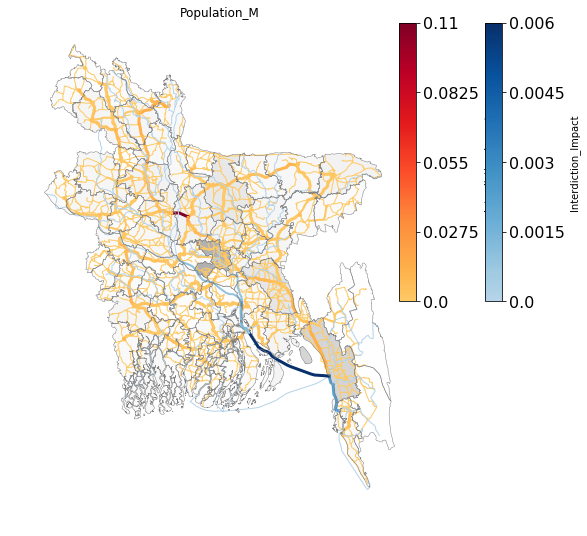

In [158]:
print('Interdiction Impact (Increase in Total Travel Cost)')
plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='Interdiction_Impact', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.11, 0.006],
                        perc1=80, perc2=90,
                        modes=['road', 'water'])

Unsatisfied Demand (ton)
maximum unsatisfied demand from road segment is 0.000317540821457
maximum unsatisfied demand from water segment is 0.0


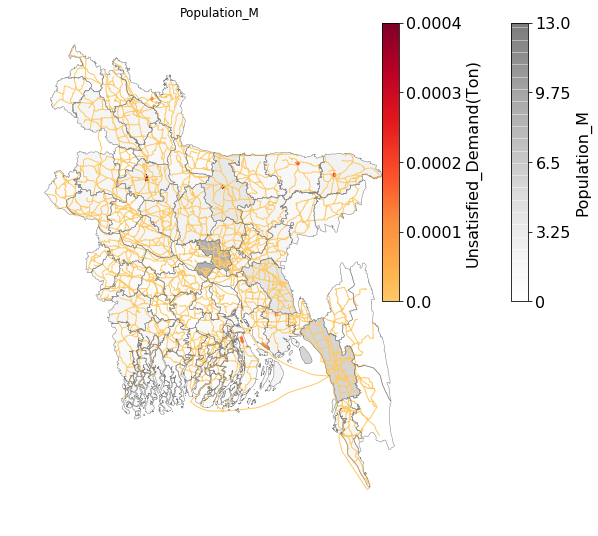

In [181]:
#TODO: plot_network_multimodal() function somehow doesn't work for this metric
#perhapse because there are only 10 out of 3500 links which score is >0

print('Unsatisfied Demand (ton)')
max_road = gdf_final.loc[gdf_final['mode']=='road']['Unsatisfied_Demand(Ton)'].max()
print('maximum unsatisfied demand from road segment is ' + str(max_road))
max_water = gdf_final.loc[gdf_final['mode']=='water']['Unsatisfied_Demand(Ton)'].max()
print('maximum unsatisfied demand from water segment is ' + str(max_water))
net_v.plot_network_admcolmap_betweenness_new(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                                       betweenness_string='Unsatisfied_Demand(Ton)', cmap=new_cmap1,
                                       maxbetweenness=0.0004, maxpop=13, perc1=0.9, perc2=0.95)